In [1]:
# 필요한 라이브러리를 설치합니다.
# PyTorch 기반 SOTA 이미지 모델 라이브러리 ; resnet34 불러오기 위함
!pip install timm

In [2]:
import os
import time

import timm # 모델
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image # 이미지 입출력
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# EDA

In [3]:
# train.csv 로드 & 기본 구조
train_df = pd.read_csv("../data/train.csv")
print(train_df.head())
print(train_df.info())
print(train_df['target'].unique())

                     ID  target
0  002f99746285dfdd.jpg      16
1  008ccd231e1fea5d.jpg      10
2  008f5911bfda7695.jpg      10
3  009235e4c9c07af5.jpg       4
4  00b2f44967580c74.jpg      16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1570 non-null   object
 1   target  1570 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 24.7+ KB
None
[16 10  4  5 15 14  9 13  7 11  2  8 12  3  0  1  6]


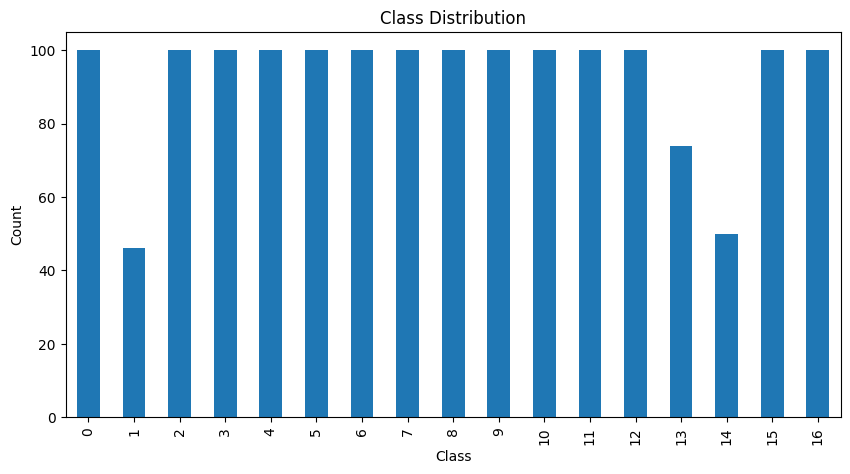

In [4]:
# 클래스 분포 확인
import matplotlib.pyplot as plt

counts = train_df['target'].value_counts().sort_index()
counts.plot(kind='bar', figsize=(10,5))
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

100%|██████████| 1570/1570 [00:00<00:00, 21248.15it/s]


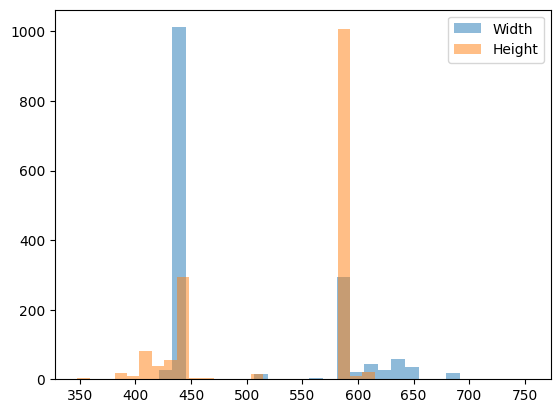

In [5]:
# 이미지 경로 확인 & 크기 분포
heights, widths = [], []
for img_id in tqdm(train_df['ID']):
    path= f"../data/train/{img_id}"
    with Image.open(path) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)
        
plt.hist(widths, bins=30, alpha=0.5, label='Width')
plt.hist(heights, bins=30, alpha=0.5, label='Height')
plt.legend()
plt.show()

# 하이퍼파라미터

In [6]:
import os, torch, math

SEED = 42
N_CLASS = 17

# 프로젝트 구조 맞춤 (지금 노트북이 code/ 폴더에 있으니 한 단계 위의 data/)
DATA_DIR = "../data"
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train")
TEST_CSV  = os.path.join(DATA_DIR, "sample_submission.csv")  # 테스트 ID용(csv 이름 다르면 바꿔)

# GPU 메모리 기준으로 preset 고르기 (원하면 고정값으로 덮어써도 됨)
def pick_preset():
    if not torch.cuda.is_available():
        return {"img_size": 320, "batch_size": 32, "accum": 1}
    total = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # GB
    if total < 10:      # ~8GB
        return {"img_size": 320, "batch_size": 32, "accum": 1}
    elif total < 18:    # ~12-16GB
        return {"img_size": 384, "batch_size": 32, "accum": 1}
    else:               # 24GB+
        return {"img_size": 448, "batch_size": 64, "accum": 1}

preset = pick_preset()

CFG = {
    # device
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),

    # data
    "train_csv": TRAIN_CSV,
    "train_img_dir": TRAIN_IMG_DIR,

    # model
    "model_name": "convnext_tiny",  # 'resnet34', 'efficientnet_b0', 'convnext_tiny' 등 timm 이름
    "num_classes": N_CLASS,

    # training
    "img_size": preset["img_size"],   # 384 권장
    "epochs": 30,
    "batch_size": preset["batch_size"],
    "grad_accum": preset["accum"],    # OOM나면 2~4로
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "warmup_epochs": 3,
    "max_grad_norm": 1.0,
    "use_amp": True,

    # dataloader
    "num_workers": max(2, (os.cpu_count() or 4) // 2),
    "pin_memory": True,
    "persistent_workers": True,
}


# Transform(Albumentations)

In [7]:
img_size = IMG_SIZE = CFG['img_size']
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# train : 강건성 확보
train_tf = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0, value=[0,0,0]),
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.6, 1.0), ratio=(0.7, 1.3), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=5, p=1.0),
        A.GaussianBlur(blur_limit=(3,7), p=1.0),
        A.MedianBlur(blur_limit=5, p=1.0),
    ], p=0.2),                 # 평가셋 블러 대응
    A.OneOf([
        A.ImageCompression(quality_lower=60, quality_upper=95, p=1.0),
        A.GaussNoise(var_limit=(5.0, 25.0), p=1.0),
    ], p=0.2),                 # 압축/노이즈 내성
    A.OneOf([
        A.HueSaturationValue(10,15,10, p=1.0),
        A.RandomBrightnessContrast(0.2,0.2, p=1.0),
    ], p=0.4),                 # 색/밝기 흔들림
    A.CoarseDropout(max_holes=1, max_height=0.25, max_width=0.25, p=0.25),  # RandomErasing 유사
    A.Normalize(),
    ToTensorV2(),
])

# 소수 클래스용 강 증강(필요 없으면 안 써도 됨)
strong_train_transform = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0, value=[0,0,0]),
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.6, 1.0), ratio=(0.7, 1.35), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=7, p=1.0),
        A.GaussianBlur(blur_limit=(5,9), p=1.0),
        A.MedianBlur(blur_limit=7, p=1.0),
    ], p=0.25),
    A.OneOf([
        A.ImageCompression(quality_lower=50, quality_upper=95, p=1.0),
        A.GaussNoise(var_limit=(10.0, 40.0), p=1.0),
    ], p=0.25),
    A.OneOf([
        A.HueSaturationValue(10,15,10, p=1.0),
        A.RandomBrightnessContrast(0.2,0.2, p=1.0),
    ], p=0.4),
    A.CoarseDropout(max_holes=1, max_height=0.25, max_width=0.25, p=0.3),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

# valid/test : 안정성 우선
valid_tf = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0, value=[0,0,0]),
    A.CenterCrop(IMG_SIZE, IMG_SIZE, p=1.0),
    A.Normalize(),
    ToTensorV2(),
])

In [24]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    """
    csv:        CSV 경로 (기본 컬럼명: ID, target)
    img_dir:    이미지 폴더 경로
    transform:  기본(약) 증강 (albumentations)
    transform_strong: 강 증강 (albumentations) — minority_set에만 적용
    minority_set: 강증강을 적용할 라벨 집합(e.g., {3, 7, 12}); None이면 미사용
    has_label:  True면 학습/검증용, False면 테스트용
    id_col:     파일명 컬럼명
    label_col:  라벨 컬럼명
    img_ext:    CSV의 ID에 확장자가 없을 때 붙일 확장자 (예: ".jpg")
    """
    def __init__(
        self,
        csv,
        img_dir,
        transform=None,
        transform_strong=None,
        minority_set=None,
        has_label=True,
        id_col="ID",
        label_col="target",
        img_ext=".jpg",
    ):
        self.df = pd.read_csv(csv).reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.transform_strong = transform_strong
        self.minority_set = set(minority_set) if minority_set is not None else None
        self.has_label = has_label
        self.id_col = id_col
        self.label_col = label_col
        self.img_ext = img_ext

        # ID에 확장자가 이미 포함되어 있는지 자동 판별
        first_id = str(self.df[self.id_col].iloc[0])
        self._id_has_ext = first_id.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"))

        # 안전장치: 테스트 모드인데 라벨 컬럼이 있으면 무시
        if not self.has_label and self.label_col in self.df.columns:
            self.df = self.df.drop(columns=[self.label_col])

    def __len__(self):
        return len(self.df)

    def _make_path(self, name: str) -> str:
        fname = name if self._id_has_ext else f"{name}{self.img_ext}"
        return os.path.join(self.img_dir, fname)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        name = str(row[self.id_col])
        path = self._make_path(name)

        # --- 이미지 읽기 + EXIF 회전 보정 (PIL에서 보정 후 넘파이 변환) ---
        try:
            with Image.open(path) as pil:
                pil = ImageOps.exif_transpose(pil)  # <-- PIL.Image에 대해 호출해야 함
                pil = pil.convert('RGB')
                img = np.array(pil)  # HWC, RGB
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Image not found: {path}") from e

        # --- transform 선택(소수 클래스라면 강증강) ---
        t = self.transform
        if self.has_label:
            target = int(row[self.label_col])
            if (self.transform_strong is not None) and (self.minority_set is not None) and (target in self.minority_set):
                t = self.transform_strong
        else:
            target = None

        if t is not None:
            img = t(image=img)["image"]  # tensor (C,H,W)

        if self.has_label:
            return img, target
        else:
            # 테스트셋은 식별자도 같이 반환하면 편함
            return img, name


In [9]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

@torch.no_grad()
def _metrics_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    acc = (preds == targets).float().mean().item()
    f1  = f1_score(targets.cpu().numpy(), preds.cpu().numpy(), average='macro')
    return acc, f1

def train_one_epoch(
    loader, model, optimizer, loss_fn, device,
    scheduler=None,                 # Cosine 등 epoch/batch 스케줄러 아무거나
    scaler=None,                    # torch.cuda.amp.GradScaler() 쓰면 혼합정밀
    grad_accum_steps=1,             # 메모리 부족 시 >1 로
    max_grad_norm=1.0,              # 클리핑 미사용이면 None
    use_amp=True                    # True면 autocast 사용
):
    model.train()
    running_loss = 0.0
    n_samples = 0

    # 전체 예측/정답 모음 (F1 계산용)
    all_preds, all_tgts = [], []

    pbar = tqdm(loader, leave=False)
    optimizer.zero_grad(set_to_none=True)

    for step, (images, targets) in enumerate(pbar, 1):
        images  = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(use_amp and torch.cuda.is_available())):
            logits = model(images)
            loss = loss_fn(logits, targets) / grad_accum_steps  # 누적학습 고려

        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        if step % grad_accum_steps == 0:
            if max_grad_norm is not None:
                if scaler is not None:
                    scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            if scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()

            optimizer.zero_grad(set_to_none=True)

            # 스케줄러가 배치 단위(step)일 경우
            if scheduler is not None and getattr(scheduler, "step_per_batch", False):
                scheduler.step()

        # 로그 집계
        bs = images.size(0)
        running_loss += loss.item() * bs * grad_accum_steps  # 복원
        n_samples += bs

        batch_preds = logits.argmax(dim=1).detach().cpu().numpy()
        batch_tgts  = targets.detach().cpu().numpy()
        all_preds.extend(batch_preds)
        all_tgts.extend(batch_tgts)

        pbar.set_description(f"loss {loss.item()*grad_accum_steps:.4f}")

    # 에폭 종료 후 지표
    epoch_loss = running_loss / max(1, n_samples)
    epoch_acc  = accuracy_score(all_tgts, all_preds)
    epoch_f1   = f1_score(all_tgts, all_preds, average='macro')

    # 스케줄러가 에폭 단위일 경우
    if scheduler is not None and not getattr(scheduler, "step_per_batch", False):
        # 일부 스케줄러는 val_metric을 받기도 함(예: ReduceLROnPlateau)
        try:
            scheduler.step(epoch_f1)
        except TypeError:
            scheduler.step()

    return {
        "train_loss": epoch_loss,
        "train_acc":  epoch_acc,
        "train_f1":   epoch_f1,
    }

@torch.no_grad()
def validate_one_epoch(loader, model, loss_fn, device, return_probs=False):
    model.eval()
    running_loss = 0.0
    n_samples = 0

    all_preds, all_tgts = [], []
    all_probs = [] if return_probs else None

    for images, targets in tqdm(loader, leave=False):
        images  = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        logits = model(images)
        loss = loss_fn(logits, targets)

        bs = images.size(0)
        running_loss += loss.item() * bs
        n_samples += bs

        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_tgts.extend(targets.cpu().numpy())
        if return_probs:
            all_probs.append(probs.cpu().numpy())

    val_loss = running_loss / max(1, n_samples)
    val_acc  = accuracy_score(all_tgts, all_preds)
    val_f1   = f1_score(all_tgts, all_preds, average='macro')

    out = {
        "val_loss": val_loss,
        "val_acc":  val_acc,
        "val_f1":   val_f1,
    }
    if return_probs:
        out["val_probs"] = np.concatenate(all_probs, axis=0)
        out["val_targets"] = np.array(all_tgts)
    return out


# 데이터 로드

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 비율 유지 + 정사각 패딩 → 학습에선 크롭으로 크롭 노이즈 내성
trn_transform = A.Compose([
    A.LongestMaxSize(max_size=img_size),
    A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=[0,0,0]),
    A.RandomResizedCrop(img_size, img_size, scale=(0.7, 1.0), ratio=(0.75, 1.33), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=5, p=1.0),
        A.GaussianBlur(blur_limit=(3,7), p=1.0),
        A.MedianBlur(blur_limit=5, p=1.0),
    ], p=0.15),  # 평가셋 블러 대응
    A.OneOf([
        A.ImageCompression(quality_lower=60, quality_upper=95, p=1.0),
        A.GaussNoise(var_limit=(5.0, 25.0), p=1.0),
    ], p=0.15),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2(),
])

# 소수 클래스용 강증강(강도 ↑): scale 더 낮추고, 색/erasing 추가
strong_train_transform = A.Compose([
    A.LongestMaxSize(max_size=img_size),
    A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=[0,0,0]),
    A.RandomResizedCrop(img_size, img_size, scale=(0.6, 1.0), ratio=(0.70, 1.35), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=7, p=1.0),
        A.GaussianBlur(blur_limit=(5,9), p=1.0),
        A.MedianBlur(blur_limit=7, p=1.0),
    ], p=0.25),
    A.OneOf([
        A.ImageCompression(quality_lower=50, quality_upper=95, p=1.0),
        A.GaussNoise(var_limit=(10.0, 40.0), p=1.0),
    ], p=0.25),
    A.OneOf([
        A.HueSaturationValue(10,15,10, p=1.0),
        A.RandomBrightnessContrast(0.2,0.2, p=1.0),
    ], p=0.4),
    A.CoarseDropout(max_holes=1, max_height=0.25, max_width=0.25, p=0.3),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2(),
])

# 검증/테스트: 비율 유지 + 센터크롭(혹은 패딩만) → 변동 최소화
tst_transform = A.Compose([
    A.LongestMaxSize(max_size=img_size),
    A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=[0,0,0]),
    A.CenterCrop(img_size, img_size, p=1.0),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2(),
])


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("../data/train.csv")

# 클래스 비율 유지하며 train/val 분리
trn_df, val_df = train_test_split(
    df,
    test_size = 0.2, # 8:2 분리
    stratify = df['target'], # 클래스 비율 유지
    random_state=42
)

# 임시 csv 저장
trn_df.to_csv('../data/train_split.csv', index=False)
val_df.to_csv('../data/val_split.csv', index=False)

In [16]:
# minority_set 로드 (그대로 OK)
minority_path = '/root/cv_data/minority_set.txt'
if os.path.exists(minority_path):
    with open(minority_path, 'r') as f:
        txt = f.read().strip()
    minority_set = set(map(int, txt.split(','))) if txt else set()
else:
    minority_set = set()

# Dataset 생성
trn_dataset = ImageDataset(
    csv="../data/train_split.csv",
    img_dir="../data/train",
    transform=trn_transform,
    transform_strong=strong_train_transform,
    minority_set=minority_set,
    has_label=True,            # (기본값 True라 생략해도 됨)
)

val_dataset = ImageDataset(
    csv="../data/val_split.csv",
    img_dir="../data/train",
    transform=tst_transform,   # val은 test와 동일 파이프라인
    has_label=True,
)

# ⚠️ sample_submission.csv에 target이 비어 있거나 NaN이면 int 변환 오류 발생 가능.
# 안전하게 has_label=False로 두고 (img, id) 반환받자.
tst_dataset = ImageDataset(
    csv="../data/sample_submission.csv",
    img_dir="../data/test",
    transform=tst_transform,
    has_label=False,           # ← 중요
)

print(len(trn_dataset), len(val_dataset), len(tst_dataset))


1256 314 3140


In [25]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch, pandas as pd, numpy as np

# === 0) 공통 하이퍼파라미터 별칭 ===
BATCH_SIZE  = CFG["batch_size"]
NUM_WORKERS = CFG["num_workers"] = min(4, os.cpu_count() or 1)
PIN_MEMORY  = CFG["pin_memory"] = True
PERSISTENT  = CFG["persistent_workers"] = True
PREFETCH = 2

# === 1) 샘플 가중치 계산: 반드시 trn_dataset과 같은 CSV 사용 ===
trn_split_path = "../data/train_split.csv"   # ★ 여기 통일
df_w = pd.read_csv(trn_split_path)

counts   = df_w["target"].value_counts().sort_index()
n_class  = counts.shape[0]
weight_map = counts.sum() / (n_class * counts)       # class별 weight = N / (K * n_c)
sample_weights = df_w["target"].map(weight_map).astype("float64").values

# 길이/라벨 일치 sanity check (선택)
assert len(sample_weights) == len(trn_dataset), "weights 길이와 trn_dataset 길이가 다릅니다."
assert set(df_w["target"].unique()) == set(range(n_class)) or len(set(df_w["target"])) == n_class

sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).to(dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

# === 2) DataLoader ===
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,          # sampler 사용 시 shuffle=False
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT if NUM_WORKERS > 0 else False,
    drop_last=False           # BN 쓰면 True 고려(ConvNeXt는 LN이라 False도 OK)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT if NUM_WORKERS > 0 else False,
    drop_last=False
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,            # 테스트는 순서 유지
    num_workers=NUM_WORKERS,  # 0 고집할 이유 없으면 동일 값 사용 OK
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT if NUM_WORKERS > 0 else False,
    drop_last=False
)

print(
    f"[sampler ready] classes={n_class}, "
    f"min_class={int(counts.min())}, max_class={int(counts.max())}, "
    f"samples={len(sample_weights)}"
)


[sampler ready] classes=17, min_class=37, max_class=80, samples=1256


In [18]:
import torch
import torch.nn as nn
import timm

device = CFG["device"]

# 1) 모델
model = timm.create_model(
    CFG["model_name"],         # 예: "convnext_tiny"
    pretrained=True,
    num_classes=CFG["num_classes"]
).to(device)

# 2) 손실함수
# 현재 train에 WeightedRandomSampler를 쓰고 있으니, 과보정 방지 위해 처음엔 weight=None 권장
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.02)   # (0.00~0.05 사이 권장)

# 3) 옵티마이저
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG["lr"],
    weight_decay=CFG["weight_decay"]
)

# 4) 스케줄러 (간단 버전: Cosine만)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=CFG["epochs"],
    eta_min=1e-6
)

# 확인용
n_params = sum(p.numel() for p in model.parameters())/1e6
print(f"model={CFG['model_name']}, params={n_params:.2f}M, img_size={CFG['img_size']}")


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

model=convnext_tiny, params=27.83M, img_size=448


In [19]:
model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [22]:
from torch.utils.data import DataLoader

# 임시 디버그용: 워커 0, 핀메모리 X
dbg_loader = DataLoader(
    trn_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

# 한 배치만 시도 → 여기서 터지면 실제 예외가 콘솔에 찍힘(FileNotFoundError, PIL 에러 등)
batch = next(iter(dbg_loader))
print("OK:", [t.shape for t in batch if hasattr(t, "shape")])


OK: [torch.Size([4, 3, 448, 448]), torch.Size([4])]


In [23]:
import os

missing = []
for i in range(len(trn_dataset)):
    name = str(trn_dataset.df.iloc[i]["ID"])
    try:
        path = trn_dataset._make_path(name)   # 우리가 만든 ImageDataset에 존재
    except AttributeError:
        # _make_path가 없다면 직접 구성
        has_ext = name.lower().endswith((".jpg",".jpeg",".png",".bmp",".gif",".webp"))
        fname = name if has_ext else f"{name}.jpg"
        path = os.path.join("../data/train", fname)
    if not os.path.exists(path):
        missing.append(path)
        if len(missing) >= 10: break

print("missing files:", len(missing))
print("\n".join(missing[:5]))


missing files: 0



In [26]:
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

scaler   = GradScaler(enabled=CFG["use_amp"])
best_f1  = -1.0
patience = 7          # 선택: 조기종료
no_improve = 0

for epoch in range(1, CFG["epochs"] + 1):
    # 1) Train (여기서 scheduler는 epoch 끝에 내부에서 step 안 되게 하기)
    tr = train_one_epoch(
        trn_loader, model, optimizer, loss_fn, CFG["device"],
        scheduler=None,           # ← 전달하면 train_one_epoch 끝에서 step
        scaler=scaler,
        grad_accum_steps=CFG["grad_accum"],
        max_grad_norm=CFG["max_grad_norm"],
        use_amp=CFG["use_amp"]
    )

    # 2) Validate
    va = validate_one_epoch(
        val_loader, model, loss_fn, CFG["device"], return_probs=False
    )

    # ====== 스케줄러는 여기서 '한 번만' ======
    if isinstance(scheduler, ReduceLROnPlateau):
        # metric으로 제어: 보통 val_loss (mode='min') 또는 val_f1 (mode='max')
        # 예) mode='max'로 만들었다면 va['val_f1'] 전달
        scheduler.step(va['val_loss'])   # or va['val_f1']
    else:
        scheduler.step()                 # Cosine/Step/OneCycle 등은 인자 없이

    curr_lr = optimizer.param_groups[0]["lr"]
    print(f"[{epoch:02d}/{CFG['epochs']}] "
          f"train_loss={tr['train_loss']:.4f}  train_f1={tr['train_f1']:.4f}  "
          f"val_loss={va['val_loss']:.4f}  val_f1={va['val_f1']:.4f}  lr={curr_lr:.6f}")

    if va["val_f1"] > best_f1:
        best_f1 = va["val_f1"]; no_improve = 0
        torch.save({"model": model.state_dict(), "epoch": epoch, "best_f1": best_f1, "cfg": CFG},
                   f"best_{CFG['model_name']}_img{CFG['img_size']}.pth")
        print(f">> best updated! val_f1={best_f1:.4f}")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f">> early stop: no improvement for {patience} epochs")
            break


[01/30] train_loss=0.8088  train_f1=0.7404  val_loss=0.7644  val_f1=0.7675  lr=0.000298
>> best updated! val_f1=0.7675


[02/30] train_loss=0.6709  train_f1=0.8092  val_loss=0.6963  val_f1=0.7893  lr=0.000294
>> best updated! val_f1=0.7893


[03/30] train_loss=0.5082  train_f1=0.8420  val_loss=0.6062  val_f1=0.8329  lr=0.000289
>> best updated! val_f1=0.8329


[04/30] train_loss=0.5082  train_f1=0.8654  val_loss=0.4874  val_f1=0.8493  lr=0.000283
>> best updated! val_f1=0.8493


[05/30] train_loss=0.4168  train_f1=0.9017  val_loss=0.4049  val_f1=0.8750  lr=0.000275
>> best updated! val_f1=0.8750


[06/30] train_loss=0.3912  train_f1=0.9182  val_loss=0.4207  val_f1=0.8869  lr=0.000265
>> best updated! val_f1=0.8869


[07/30] train_loss=0.3439  train_f1=0.9297  val_loss=0.4050  val_f1=0.9013  lr=0.000255
>> best updated! val_f1=0.9013


[08/30] train_loss=0.3183  train_f1=0.9391  val_loss=0.4625  val_f1=0.8830  lr=0.000243


[09/30] train_loss=0.3307  train_f1=0.9289  val_loss=0.4386  val_f1=0.8935  lr=0.000230


[10/30] train_loss=0.2886  train_f1=0.9494  val_loss=0.4352  val_f1=0.9005  lr=0.000217


[11/30] train_loss=0.2652  train_f1=0.9585  val_loss=0.4338  val_f1=0.8969  lr=0.000202


[12/30] train_loss=0.2389  train_f1=0.9674  val_loss=0.4094  val_f1=0.9090  lr=0.000187
>> best updated! val_f1=0.9090


[13/30] train_loss=0.2118  train_f1=0.9800  val_loss=0.4287  val_f1=0.8967  lr=0.000172


[14/30] train_loss=0.2208  train_f1=0.9761  val_loss=0.4130  val_f1=0.9188  lr=0.000156
>> best updated! val_f1=0.9188


[15/30] train_loss=0.2051  train_f1=0.9791  val_loss=0.3922  val_f1=0.9260  lr=0.000141
>> best updated! val_f1=0.9260


[16/30] train_loss=0.1923  train_f1=0.9840  val_loss=0.3755  val_f1=0.9305  lr=0.000125
>> best updated! val_f1=0.9305


[17/30] train_loss=0.2084  train_f1=0.9762  val_loss=0.3966  val_f1=0.8881  lr=0.000110


[18/30] train_loss=0.1735  train_f1=0.9922  val_loss=0.4400  val_f1=0.9234  lr=0.000095


[19/30] train_loss=0.1673  train_f1=0.9969  val_loss=0.3545  val_f1=0.9391  lr=0.000081
>> best updated! val_f1=0.9391


[20/30] train_loss=0.1669  train_f1=0.9975  val_loss=0.4728  val_f1=0.9148  lr=0.000067


[21/30] train_loss=0.1656  train_f1=0.9961  val_loss=0.4078  val_f1=0.9273  lr=0.000055


[22/30] train_loss=0.1615  train_f1=0.9961  val_loss=0.4077  val_f1=0.9286  lr=0.000043


[23/30] train_loss=0.1518  train_f1=1.0000  val_loss=0.3900  val_f1=0.9345  lr=0.000033


[24/30] train_loss=0.1566  train_f1=0.9992  val_loss=0.3834  val_f1=0.9378  lr=0.000024


[25/30] train_loss=0.1565  train_f1=0.9984  val_loss=0.3782  val_f1=0.9262  lr=0.000016


[26/30] train_loss=0.1537  train_f1=0.9981  val_loss=0.3797  val_f1=0.9351  lr=0.000010
>> early stop: no improvement for 7 epochs


# 추론

In [27]:
# 체크포인트 로드
import torch, os

device = CFG["device"]

# 네가 저장한 최신 포맷 (앞서 학습 루프에서 저장)
ckpt_new = f"best_{CFG['model_name']}_img{CFG['img_size']}.pth"
# 예전 파일명도 혹시 남아있을 수 있으니 fallback
ckpt_old = "best_resnet34_2.pth"

ckpt_path = ckpt_new if os.path.exists(ckpt_new) else ckpt_old
print("loading ckpt:", ckpt_path)

ckpt = torch.load(ckpt_path, map_location=device)
state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
missing, unexpected = model.load_state_dict(state_dict, strict=False)
if missing or unexpected:
    print("[state_dict] missing:", missing, "unexpected:", unexpected)

model.to(device)
model.eval()


loading ckpt: best_convnext_tiny_img448.pth


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [28]:
# 추론
import numpy as np
import pandas as pd
from tqdm import tqdm

ids, preds = [], []

torch.set_grad_enabled(False)
for images, names in tqdm(tst_loader):
    images = images.to(device, non_blocking=True)
    logits = model(images)
    pred = logits.argmax(dim=1).detach().cpu().numpy()

    ids.extend(names)     # ImageDataset(has_label=False)에서 반환한 식별자
    preds.extend(pred.tolist())

print("num predictions:", len(preds))


100%|██████████| 50/50 [00:12<00:00,  4.13it/s]

num predictions: 3140


In [30]:
# preds_list 길이 = 테스트 샘플 수 체크
assert len(preds) == len(tst_dataset), "예측 개수와 테스트셋 길이가 다릅니다."

In [32]:
# ID만 복사해서 target 채우기
pred_df = tst_dataset.df[["ID"]].copy()
pred_df["target"] = np.array(preds, dtype=int)

In [33]:
# 샘플 제출과 순서 일치 확인(강추)
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df["ID"].values == pred_df["ID"].values).all(), "ID 순서가 다릅니다."


In [34]:
# 값/자료형 점검(선택)
assert pred_df["target"].between(0, 16).all(), "라벨 범위(0~16) 확인!"

In [35]:
pred_df.to_csv("code4_pred.csv", index=False)
print("Saved -> code4_pred.csv")

Saved -> code4_pred.csv
